# Navigating by Falling Stars: Monetary Policy with Fiscally Driven Natural Rates
## Computation of alternative steady states

This notebook does the following:
1. Starting from our initial calibration, it solves the steady state for various levels of debt under three different assumptions ("regimes").
   - Government consumption adjusts to obtain a new SS
   - The labor tax rate adjusts to obtain a new SS
   - Transfers adjust to obtain a new SS
3. It produces Figures 1a, 1b, 2a, and 2b in the paper.
4. It produces Figure 8 in Appendix E.
5. It saves intermediate results to the file `results/ss_graphs.json`. This file contains the data used in figures.

### Requirements
The code requires that the file `ss/ss_hank_ini.json` that contains the calibration and initial steady state exists. It imports the household block and the model from the file `model.py` and a Broyden solver from `utils.py`. The code is otherwise self-contained.

In [5]:
# Standard imports
import json
import os
import numpy as np
import matplotlib.pyplot as plt

import sequence_jacobian as sj  # note: sequence_jacobian has scipy as a dependency
from model import hank_lb, hh_ext
from utils import broyden_solver

In [6]:
@sj.simple
def G_rule_ss(rb, tax, w, N, Transfer, Bg, T_d):
    T = tax * w * N + T_d
    G = T - Transfer - rb * Bg
    Bres = rb * Bg + (G + Transfer) - T
    Gbar = G
    Bgbar = Bg
    FD = 0  # fiscal deficit
    PD = Transfer + G - T  # primary deficit (does not include interest payments)
    return G, Bres, Gbar, Bgbar, FD, PD, T

def ssmap_regime(ss, ra, Y, Bg):
    """Find new steady state given rb"""
    # evaluate production side
    capital_share = ss['alpha'] / ss['mup']
    K = (capital_share / (ra + ss['delta'])) * Y
    N = (Y / ss['Z'] / K ** ss['alpha']) ** (1 / (1 - ss['alpha']))
    labor_share = (1 - ss['alpha']) / ss['mup']
    w = labor_share * Y / N
    I = ss['delta'] * K
    div = (Y - w * N - I) * (1-ss['tau_d'])
    T_d =  (Y - w * N - I) * ss['tau_d']  
    
    p = div / ra  # (Y - w * N - r * K) / ra + (1 - delta/ra) * K

    # calculate fiscal variables depending on the chosen regime
    regime = ss['regime']
    if regime == 'G':
        Transfer = ss['Transfer']
        tax = ss['tax']
        T = tax * w * N + T_d
        G = T - Transfer - ss['rb'] * Bg
        Gbar = G
    elif regime == 'tax':
        G = ss['G']
        Gbar = ss['Gbar']
        Transfer = ss['Transfer']
        T = G + Transfer + ss['rb'] * Bg  # tax revenue needed in SS
        tax = (T - T_d) / (w * N)  # labor tax rate needed to finance T
    elif regime == 'Transfer':
        G = ss['G']
        Gbar = ss['Gbar']
        tax = ss['tax']
        T = tax * w * N + T_d
        Transfer = T - G - ss['rb'] * Bg
    else:
        raise ValueError(f"Unknown regime '{regime}'. Choose regime from the options 'G', 'tax', or 'Transfer'.")

    Bgbar = Bg
    
    # evaluate household
    d = {**ss, 'N': N, 'w': w, 'tax': tax, 'Transfer': Transfer, 'ra': ra}
    out = hh_ext.steady_state(d)
    A = out['A']
    B = out['B']
    C = out['C']
    
    # create residuals
    asset_mkt = out['A'] - p
    bond_mkt = B - Bg
    labor_mkt = ss['vphi'] * N ** (1 / ss['frisch']) - (1 - tax) * w * out['UCE'] / ss['muw']

    # other things of interest
    Chi = out['CHI']
    goods_mkt = C + I + G + Chi - Y
    i = (1+ss['pi']) * (1+ss['rb']) - 1

    return asset_mkt, labor_mkt, bond_mkt, {**ss, **out, **dict(K=K, N=N, w=w, I=I, div=div, p=p, G=G, Gbar=Gbar, Bgbar=Bgbar,
                                                      Transfer=Transfer, tax=tax, Y=Y, C=C, ra_e=ra,
                                                      Bg=Bg, ra=ra, Chi=Chi, goods_mkt=goods_mkt,
                                                      rbar=ss['rb'], i=i)}


def hank_ss_rb(rb, ss, regime='G'):
    num_x = 3
    # Compute new equilibrium level of output and ra    
    ssalt = {**ss, 'rb': rb, 'rb_e': rb, 'regime': regime}
    (ra, Y, Bg), _ = broyden_solver(lambda x: np.array(ssmap_regime(ssalt, *x)[:num_x]), np.array([ss['ra'], ss['Y'], ss['Bg']]), tol=1e-5)
    ssnew = ssmap_regime(ssalt, ra, Y, Bg)[num_x]

    # Check Walras law
    #assert ssnew['goods_mkt'] < 1E-7
    print(ssnew['goods_mkt'])

    return ssnew

def is_residual(name):
    if '_res' in name:
        return True
    elif '_mkt' in name:
        return True
    else:
        return False
    
def annualize(s):
    s = np.array(s)
    sa = (1 + s) ** 4 - 1
    return sa

def de_annualize(s):
    s = np.array(s)
    sa = (1 + s) ** 0.25 - 1
    return sa

## Load calibration

In [7]:
data = json.load(open(os.path.join("ss", "ss_hank_ini.json")))
ss_hank_ini = hank_lb.steady_state(data, dissolve=['G_rule', 'taylor_smooth'])

print("-" * 80)
print("Initial SS")
for k, v in ss_hank_ini.toplevel.items():
    if is_residual(k):
        print(f"{k}: {v:.6f}")

--------------------------------------------------------------------------------
Initial SS
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000002
bond_mkt: -0.000000
goods_mkt: 0.000000


## Different steady states

In [8]:
# Compute the steady states for a range of values of d_Bg

# Initialize dictionary
ss_dict = {}

regimes = ['G', 'tax', 'Transfer']
values = [0.012, 0.014, 0.016, 0.018, 0.02, 0.022]

for regime in regimes:
    ss = ss_hank_ini.copy()  # start from baseline
    ss_dict[regime] = {0.01: ss}  # initialize regime
    for val in values:
        print(f"Compute the new steady state with rb = {val:.3f} for regime '{regime}'...")
        rb = de_annualize(val)
        c_new = hank_ss_rb(rb, ss, regime=regime)
        ss_new = hank_lb.steady_state(c_new, dissolve=['G_rule', 'taylor_smooth'])
        ss = ss_new
        for k, v in ss.toplevel.items():
            if is_residual(k):
                print(f"{k}: {v:.6f}")

        ss_dict[regime][val] = ss


Compute the new steady state with rb = 0.012 for regime 'G'...
On iteration 0
x = 0.008, 1.000, 2.800
y = -0.749, -0.003, 0.322


On iteration 1
x = 0.008, 0.998, 3.051
y = 0.018, 0.000, -0.001


On iteration 2
x = 0.008, 0.998, 3.052
y = -0.001, -0.000, 0.000


On iteration 3
x = 0.008, 0.998, 3.052
y = -0.000, -0.000, 0.000


4.220905314156198e-08
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: 0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: 0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.014 for regime 'G'...
On iteration 0
x = 0.008, 0.998, 3.052
y = -0.837, -0.003, 0.366


On iteration 1
x = 0.008, 0.997, 3.334
y = 0.023, 0.000, -0.001


On iteration 2
x = 0.008, 0.997, 3.335
y = -0.002, -0.000, 0.000


On iteration 3
x = 0.008, 0.997, 3.335
y = -0.000, -0.000, 0.000


3.625563405051935e-08
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
i_res: -0.

On iteration 0
x = 0.008, 1.001, 3.391
y = -0.805, -0.005, 0.429


On iteration 1
x = 0.008, 1.002, 3.753
y = 0.021, 0.000, -0.001


On iteration 2
x = 0.008, 1.002, 3.754
y = -0.001, -0.000, 0.000


On iteration 3
x = 0.008, 1.002, 3.754
y = -0.000, -0.000, 0.000


On iteration 4
x = 0.008, 1.002, 3.754
y = -0.000, -0.000, 0.000


4.7599658437036396e-08
inv_res: 0.000000
val_res: -0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: 0.000000
equity_res: 0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: 0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.018 for regime 'Transfer'...
On iteration 0
x = 0.008, 1.002, 3.754
y = -0.928, -0.005, 0.502


On iteration 1
x = 0.008, 1.003, 4.176
y = 0.029, 0.000, -0.002


On iteration 2
x = 0.008, 1.004, 4.177
y = -0.002, -0.000, 0.000


On iteration 3
x = 0.008, 1.003, 4.177
y = -0.000, -0.000, 0.000


On iteration 4
x = 0.008, 1.003, 4.177
y = -0.000, -0.000, 0.000


4.8540194974577844e-08
in

In [9]:
print('-' * 80)
print("SS graph when G changes")
for k, ss in ss_dict['G'].items():
    print(f"{k}: {ss['B']/4:.6f}")

print('-' * 80)
print("SS graph when Transfer changes")
for k, ss in ss_dict['Transfer'].items():
    print(f"{k}: {ss['B']/4:.6f}")

print('-' * 80)
print("SS graph when tax changes")
for k, ss in ss_dict['tax'].items():
    print(f"{k}: {ss['B']/4:.6f}")

--------------------------------------------------------------------------------
SS graph when G changes
0.01: 0.700000
0.012: 0.763082
0.014: 0.833852
0.016: 0.913743
0.018: 1.004371
0.02: 1.108028
0.022: 1.227377
--------------------------------------------------------------------------------
SS graph when Transfer changes
0.01: 0.700000
0.012: 0.768871
0.014: 0.847626
0.016: 0.938434
0.018: 1.044148
0.02: 1.168513
0.022: 1.316892
--------------------------------------------------------------------------------
SS graph when tax changes
0.01: 0.700000
0.012: 0.755995
0.014: 0.817383
0.016: 0.884890
0.018: 0.959301
0.02: 1.041540
0.022: 1.132909


In [12]:
regimes = ['G', 'tax', 'Transfer']
values = [0.0075, 0.005, 0.0025, 0.000, -0.005, -0.0025, -0.005, -0.0075, -0.01, -0.015, -0.02, -0.03, -0.04, -0.05]

for regime in regimes:
    ss = ss_hank_ini.copy()  # start from baseline
    for val in values:
        print(f"Compute the new steady state with rb = {val:.3f} for regime '{regime}'...")
        rb = de_annualize(val)
        c_new = hank_ss_rb(rb, ss, regime=regime)
        ss_new = hank_lb.steady_state(c_new, dissolve=['G_rule', 'taylor_smooth'])
        ss = ss_new
        for k, v in ss.toplevel.items():
            if is_residual(k):
                print(f"{k}: {v:.6f}")

        ss_dict[regime][val] = ss


Compute the new steady state with rb = 0.007 for regime 'G'...
On iteration 0
x = 0.008, 1.000, 2.800
y = 0.850, 0.003, -0.345


On iteration 1
x = 0.008, 1.002, 2.520
y = 0.032, 0.000, -0.001


On iteration 2
x = 0.008, 1.002, 2.521
y = 0.002, 0.000, -0.000


On iteration 3
x = 0.008, 1.002, 2.521
y = 0.000, 0.000, -0.000


8.667028339459648e-08
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000005
bond_mkt: -0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.005 for regime 'G'...
On iteration 0
x = 0.008, 1.002, 2.521
y = 0.750, 0.003, -0.298


On iteration 1
x = 0.008, 1.003, 2.276
y = 0.026, 0.000, -0.001


On iteration 2
x = 0.008, 1.003, 2.277
y = 0.002, 0.000, -0.000


On iteration 3
x = 0.008, 1.003, 2.277
y = 0.000, 0.000, -0.000


6.65449066961088e-08
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
i_res: -0.000000
q_

On iteration 3
x = 0.008, 1.003, 2.547
y = 0.000, 0.000, -0.000


On iteration 4
x = 0.008, 1.003, 2.547
y = -0.000, -0.000, -0.000


4.596233194043009e-08
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: -0.000000
rpost_res: 0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000000
bond_mkt: -0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.005 for regime 'tax'...
On iteration 0
x = 0.008, 1.003, 2.547
y = 0.813, 0.003, -0.293


On iteration 1
x = 0.008, 1.005, 2.318
y = 0.029, 0.000, -0.001


On iteration 2
x = 0.008, 1.005, 2.320
y = 0.002, 0.000, -0.000


On iteration 3
x = 0.008, 1.005, 2.320
y = 0.000, 0.000, -0.000


1.1108659347947025e-07
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: 0.000000
equity_res: -0.000000
wnkpc_res: 0.000000
asset_mkt: 0.000008
bond_mkt: -0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.003 for regime 'tax'...

inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: 0.000000
B_res: 0.000000
equity_res: 0.000000
wnkpc_res: -0.000000
asset_mkt: -0.000002
bond_mkt: 0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.005 for regime 'Transfer'...
On iteration 0
x = 0.008, 0.999, 2.501
y = 0.604, 0.004, -0.295


On iteration 1
x = 0.008, 0.999, 2.243
y = 0.018, 0.000, -0.001


On iteration 2
x = 0.008, 0.999, 2.244
y = 0.001, 0.000, -0.000


On iteration 3
x = 0.008, 0.999, 2.244
y = 0.000, -0.000, -0.000


4.6778765860899796e-08
inv_res: 0.000000
val_res: 0.000000
nkpc_res: 0.000000
q_lb_res: 0.000000
rpost_res: -0.000000
B_res: -0.000000
equity_res: 0.000000
wnkpc_res: -0.000000
asset_mkt: 0.000000
bond_mkt: -0.000000
goods_mkt: 0.000000
Compute the new steady state with rb = 0.003 for regime 'Transfer'...
On iteration 0
x = 0.008, 0.999, 2.244
y = 0.534, 0.004, -0.254


On iteration 1
x = 0.008, 0.999, 2.020
y = 0.015, 0.000, -0.000


On iteration 2

In [13]:
print('-' * 80)
print("SS graph when G changes")
for k, ss in ss_dict['G'].items():
    print(f"{k}: {ss['B']/4:.6f}")

print('-' * 80)
print("SS graph when Transfer changes")
for k, ss in ss_dict['Transfer'].items():
    print(f"{k}: {ss['B']/4:.6f}")

print('-' * 80)
print("SS graph when tax changes")
for k, ss in ss_dict['tax'].items():
    print(f"{k}: {ss['B']/4:.6f}")

--------------------------------------------------------------------------------
SS graph when G changes
0.01: 0.700000
0.012: 0.763082
0.014: 0.833852
0.016: 0.913743
0.018: 1.004371
0.02: 1.108028
0.022: 1.227377
0.0075: 0.630304
0.005: 0.569189
0.0025: 0.515479
0.0: 0.467986
-0.005: 0.387873
-0.0025: 0.425703
-0.0075: 0.353938
-0.01: 0.323329
-0.015: 0.270690
-0.02: 0.227343
-0.03: 0.161313
-0.04: 0.114855
-0.05: 0.081698
--------------------------------------------------------------------------------
SS graph when Transfer changes
0.01: 0.700000
0.012: 0.768871
0.014: 0.847626
0.016: 0.938434
0.018: 1.044148
0.02: 1.168513
0.022: 1.316892
0.0075: 0.625245
0.005: 0.560916
0.0025: 0.505237
0.0: 0.456515
-0.005: 0.375495
-0.0025: 0.413570
-0.0075: 0.341545
-0.01: 0.311191
-0.015: 0.259366
-0.02: 0.217069
-0.03: 0.153215
-0.04: 0.108714
-0.05: 0.077129
--------------------------------------------------------------------------------
SS graph when tax changes
0.01: 0.700000
0.012: 0.7559

In [14]:
# Save data
data = {r: {k: v.toplevel for (k, v) in ss_dict[r].items()} for r in ss_dict.keys()}

# Serialize data into file:
json.dump(data, open(os.path.join("results", "ss_graphs.json"), 'w'), indent=4)

## Figures in the paper

In [15]:
# Load data
data = json.load(open(os.path.join("results", "ss_graphs.json")))
data = {r: {float(k): v for (k, v) in data[r].items()} for r in data.keys()}  # {float(k): v for k, v in data.items()}  # Convert strings to floats

In [16]:
A_list = []
B_list = []
K_list = []
ra_list = []
rb_list = []
i_list = []

B_list_Transfer = []
B_list_tax = []

keys = list(data['G'].keys())
keys.sort()

for k in keys:
    A_list.append(data['G'][k]['A']/data['G'][k]['Y']/4)
    B_list.append(data['G'][k]['B']/data['G'][k]['Y']/4)
    K_list.append(data['G'][k]['K']/data['G'][k]['Y']/4)
    ra_list.append(data['G'][k]['ra'])
    rb_list.append(data['G'][k]['rb'])
    i_list.append(data['G'][k]['i'])
    
    B_list_Transfer.append(data['Transfer'][k]['B']/data['Transfer'][k]['Y']/4)
    B_list_tax.append(data['tax'][k]['B']/data['tax'][k]['Y']/4)


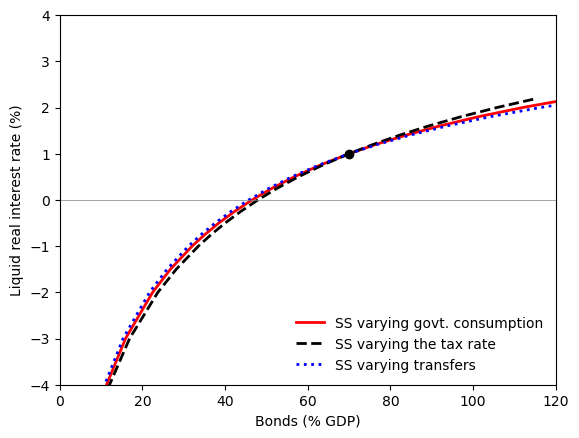

In [17]:
# Figure showing the liquid interest rate for varying levels of debt depending on which fiscal variable adjusts.
# This is Figure 8 in Appendix E.

fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*annualize(rb_list), color="red", linewidth=2, label=r"SS varying govt. consumption")
ax.plot(100*np.array(B_list_tax), 100*annualize(rb_list), color="black", ls='--', linewidth=2, label=r"SS varying the tax rate")
ax.plot(100*np.array(B_list_Transfer), 100*annualize(rb_list), color="blue", ls=':', linewidth=2, label=r"SS varying transfers")
ax.plot([70.0], [1.0], marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Liquid real interest rate (%)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=-4, top=4)
ax.legend(loc='lower right', frameon=False)

savename = os.path.join("results", "Eq_B_rb_regimes.pdf") 
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

In [18]:
# Semi-elasticities depending on which fiscal variable adjusts
# Note: result for G differs from the one reported in the paper because this experiment considers a change in B of different size

Bg_base = data['G'][0.01]['Bg']
Bg_G = data['G'][0.012]['Bg']
Bg_tax = data['tax'][0.012]['Bg']
Bg_Transfer = data['Transfer'][0.012]['Bg']

elasticity_G = 100 * 0.002 / np.log(Bg_G / Bg_base)
elasticity_tax = 100 * 0.002 / np.log(Bg_tax / Bg_base)
elasticity_Transfer = 100 * 0.002 / np.log(Bg_Transfer / Bg_base)

print(f"The semi-elasticity when G changes is: {elasticity_G:.2f}")
print(f"The semi-elasticity when tax changes is: {elasticity_tax:.2f}")
print(f"The semi-elasticity when Transfer changes is: {elasticity_Transfer:.2f}")

The semi-elasticity when G changes is: 2.32
The semi-elasticity when tax changes is: 2.60
The semi-elasticity when Transfer changes is: 2.13


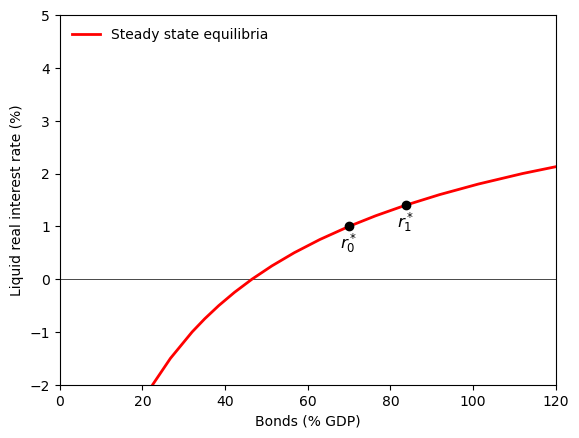

In [19]:
# Figure 1a

fig, ax = plt.subplots()
ax.axhline(y=0.0, color='black', linestyle='-', linewidth=0.5)
ax.plot(100*np.array(B_list), 100*annualize(rb_list), color="red", linewidth=2, label=r"Steady state equilibria")

point = ax.plot(100*np.array(B_list)[13], 100*annualize(rb_list)[13], marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")[0]
ax.text(100*np.array(B_list)[13],0.9,r'$r^*_0$',fontsize=12, ha='center',va='top')
point = ax.plot(100*np.array(B_list)[15], 100*annualize(rb_list)[15], marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")[0]
ax.text(100*np.array(B_list)[15],1.3,r'$r^*_1$',fontsize=12, ha='center',va='top')

ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Liquid real interest rate (%)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=-2, top=5)
#ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(loc='upper left', frameon=False)

savename = os.path.join("results", "ikeda_0.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

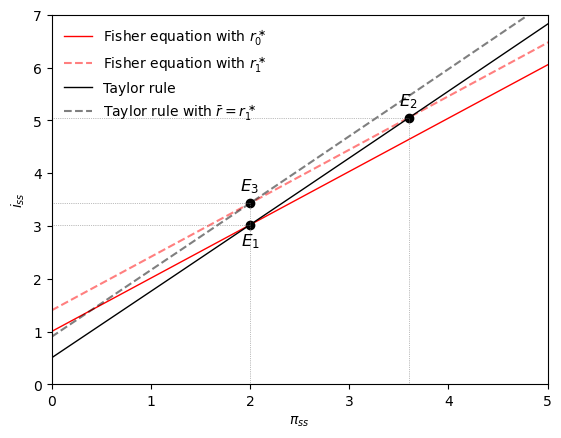

In [20]:
# Figure 1b

fig, ax = plt.subplots()
# Second Plot: Fisher Equation and Taylor Rule
pi = np.linspace(0, 0.06, 1000)  # Inflation range from 0% to 4%

# Fisher equation (i = r + pi)
r_bar = annualize(rb_list)[13]  # real interest rate -> annualize(rb_list)[13]
r_bar_high = annualize(rb_list)[15]  # real interest -> rate annualize(rb_list)[15]
i_fisher_1 = (1 + r_bar) * (1 + pi) - 1
i_fisher_2 = (1 + r_bar_high) * (1 + pi) - 1

# Taylor rule
pi_target = 0.02  # 2% inflation target
phi = 1.25  # Taylor rule coefficient
i_taylor = (1 + r_bar) * (1 + pi_target) * ((1 + pi)/(1 + pi_target))**phi - 1
i_taylor_2 = (1 + r_bar_high) * (1 + pi_target) * ((1 + pi)/(1 + pi_target))**phi - 1

# Plot Fisher equation and Taylor rule
ax.plot(100*pi, 100*i_fisher_1, color="red", linewidth=1, label=r"Fisher equation with $r^\ast_0$")
ax.plot(100*pi, 100*i_fisher_2, color="red",alpha=0.5, linestyle='--', linewidth=1.5, label=r"Fisher equation with $r^\ast_1$")
ax.plot(100*pi, 100*i_taylor, color="black", linestyle='-', linewidth=1, label="Taylor rule")
ax.plot(100*pi, 100*i_taylor_2, color="black", alpha=0.5, linestyle='--', linewidth=1.5, label=r"Taylor rule with $\bar{r}=r^\ast_1$")

# Find and plot equilibrium points
# E1: Target inflation equilibrium
pi_1 = pi_target
i_1 = (1 + r_bar) * (1 + pi_1) - 1
point = ax.plot(100*pi_1, 100*i_1, marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")[0]
ax.text(100*pi_1,2.9,r'$E_1$',fontsize=12, ha='center',va='top')

# E2: Higher inflation equilibrium
pi_2 = pi_target + (r_bar_high-r_bar)/(phi-1)
i_2 = (1 + r_bar_high) * (1 + pi_2) - 1
point = ax.plot(100*pi_2, 100*i_2, marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")[0]
ax.text(100*pi_2,100*i_2+0.5,'$E_2$',fontsize=12, ha='center',va='top')

i_3 = (1 + r_bar_high) * (1 + pi_target) - 1
point = ax.plot(100*pi_1, 100*i_3, marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")[0]
ax.text(100*pi_1,100*i_3+0.5,'$E_3$',fontsize=12, ha='center',va='top')

# Add vertical lines for equilibrium points
mycolor="gray"
ax.vlines(100*pi_1, 0, 100*i_3, linestyles=':', colors=mycolor, linewidth=0.5)
ax.vlines(100*pi_2, 0, 100*i_2, linestyles=':', colors=mycolor, linewidth=0.5)
ax.hlines(100*i_1, 0, 100*pi_1, linestyles=':', colors=mycolor, linewidth=0.5)
ax.hlines(100*i_2, 0, 100*pi_2, linestyles=':', colors=mycolor, linewidth=0.5)
ax.hlines(100*i_3, 0, 100*pi_1, linestyles=':', colors=mycolor, linewidth=0.5)

# Configure second plot
ax.set_xlabel(r"$\pi_{ss}$")
ax.set_ylabel(r"$i_{ss}$")
ax.legend(loc='upper left', frameon=False)
ax.set_xlim(0, 5)
ax.set_ylim(0, 7)
#ax.grid(True, linestyle='--', alpha=0.3)
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)


savename = os.path.join("results", "ikeda_2.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

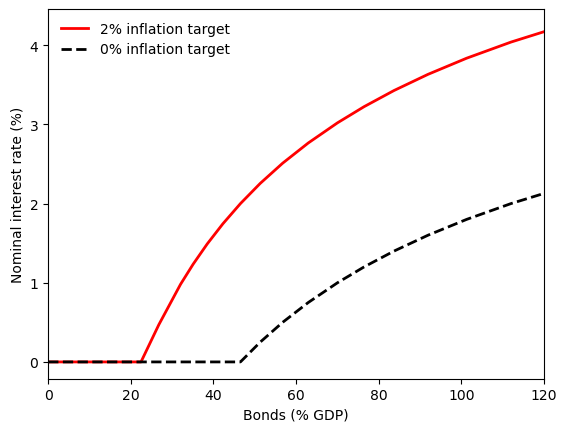

In [21]:
# Figure 2a

i_zlb_2 = list(np.maximum(i_list, np.zeros(len(i_list))))
i_zlb_0 = list(np.maximum(np.array(rb_list), np.zeros(len(i_list))))

fig, ax = plt.subplots()
ax.plot(100*np.array([0.0] + B_list), 100*annualize([0.0] + i_zlb_2), color="red", lw=2, label="2% inflation target")
ax.plot(100*np.array([0.0] + B_list), 100*annualize([0.0] + i_zlb_0), color="black",  lw=2, ls='--', label="0% inflation target")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Nominal interest rate (%)")
ax.legend(loc='best', frameon=False)
ax.set_xlim(left=0.0, right=120.0)

savename = os.path.join("results", "i.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

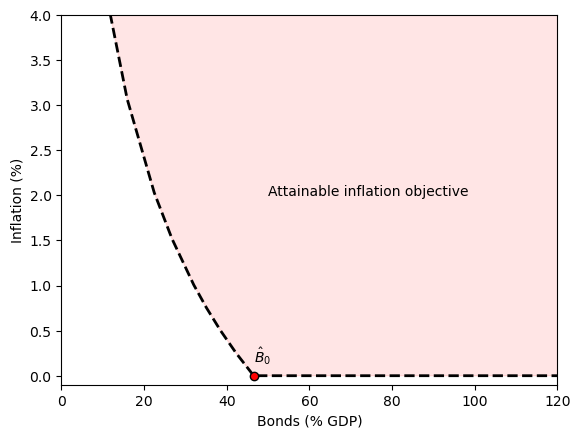

In [22]:
# Figure 2b

pibar_0 = np.array(i_zlb_0) - np.array(rb_list)
Bbar0 = 100 * data['G'][0.0]['B'] / data['G'][0.0]['Y'] / 4

fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*annualize(pibar_0), color="black", lw=2, ls='--')
ax.fill_between(100*np.array(B_list), 100*annualize(pibar_0), 4, color='red', alpha=.1)
ax.plot([Bbar0], [0.0], marker="o", markersize=6, markeredgecolor="k", markerfacecolor="red")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Inflation (%)")
ax.set_ylim(bottom=-0.1, top=4.0)
ax.set_xlim(left=0.0, right=120.0)
plt.annotate("Attainable inflation objective", (50, 2))
plt.annotate(r"$\hat{B}_0$", (Bbar0, 0.15))

savename = os.path.join("results", "pi_area.pdf")
plt.savefig(savename, format="pdf")
plt.show()
plt.close()

## Addendum: additional figures that do not appear in the paper, but which were used in our slides at some point

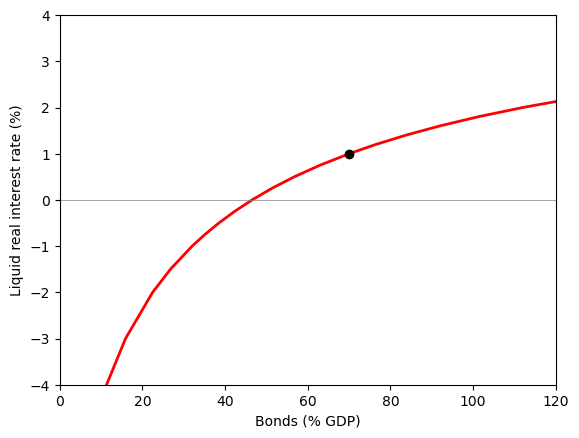

In [23]:
fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*annualize(rb_list), color="red", linewidth=2, label=r"Equilibrium")
ax.plot([70.0], [1.0], marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Liquid real interest rate (%)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=-4, top=4)
# ax.legend(loc='lower center', frameon=False)

savename = os.path.join("results", "Eq_B_rb.pdf") 
#plt.savefig(savename, format="pdf")
plt.show()
plt.close()

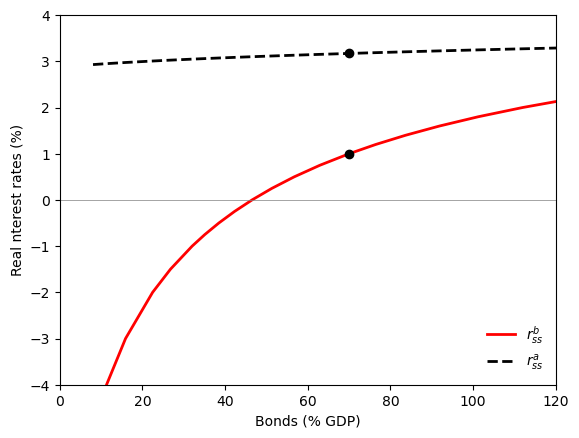

In [24]:
fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*annualize(rb_list), color="red", linewidth=2, label=r"$r^b_{ss}$")
ax.plot(100*np.array(B_list), 100*annualize(ra_list), color="black", ls="--", linewidth=2, label=r"$r^a_{ss}$")
ax.plot([70.0], 100 * annualize(data['G'][0.01]['ra']), marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.plot([70.0], 100 * annualize(data['G'][0.01]['rb']), marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Real nterest rates (%)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=-4, top=4)
ax.legend(loc='best', frameon=False)

savename = os.path.join("results", "Eq_B_ra_rb.pdf")
# plt.savefig(savename, format="pdf")
plt.show()
plt.close()

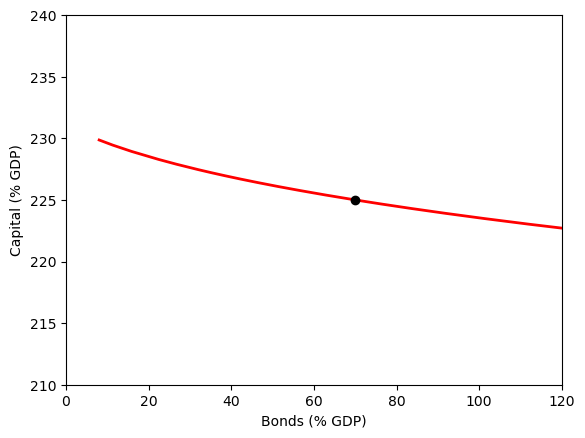

In [25]:
fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*np.array(K_list), color="red", linewidth=2, label=r"Equilibrium")
ax.plot([70.0], 100 * (data['G'][0.01]['K']/4), marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Capital (% GDP)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=210, top=240)
# ax.legend(loc='lower center', frameon=False)

savename = os.path.join("results", "Eq_B_K.pdf")
#plt.savefig(savename, format="pdf")
plt.show()
plt.close()

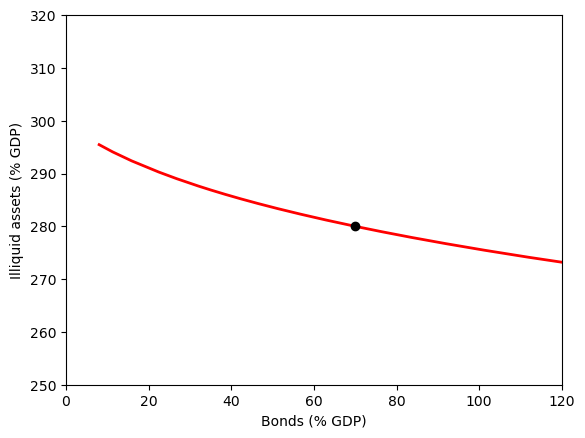

In [26]:
fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*np.array(A_list), color="red", linewidth=2, label=r"Equilibrium")
ax.plot([70.0], 100 * (data['G'][0.01]['A']/4), marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Illiquid assets (% GDP)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=250, top=320)
# ax.legend(loc='lower center', frameon=False)

savename = os.path.join("results", "Eq_B_A.pdf")
# plt.savefig(savename, format="pdf")
plt.show()
plt.close()

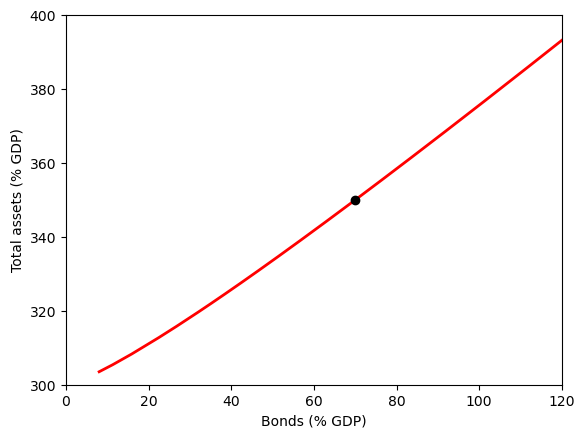

In [27]:
fig, ax = plt.subplots()
ax.plot(100*np.array(B_list), 100*(np.array(A_list)+np.array(B_list)), color="red", linewidth=2, label=r"Equilibrium")
ax.plot([70.0], 100 * (data['G'][0.01]['A']+data['G'][0.01]['B'])/4, marker="o", markersize=6, markeredgecolor="black", markerfacecolor="black")
ax.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.5)
#ax.axvline(x=70.0, color='k', linestyle='--', linewidth=2, label=r"$\overline{B}$")
ax.set_xlabel("Bonds (% GDP)")
ax.set_ylabel("Total assets (% GDP)")
ax.set_xlim(left=0, right=120)
ax.set_ylim(bottom=300, top=400)
# ax.legend(loc='lower center', frameon=False)

savename = os.path.join("results", "Eq_B_AB.pdf")
# plt.savefig(savename, format="pdf")
plt.show()
plt.close()